In [1]:
import ast
import gc
import json
import pathlib
import sys

import numpy as np
import pandas as pd
import toml
import torch
from sklearn import preprocessing

MLP_parent_path = pathlib.Path("../../../utils/")
sys.path.append(str(MLP_parent_path.resolve()))
MLP_path = pathlib.Path("../../../utils/MLP_utils").resolve()

import argparse

import matplotlib.pyplot as plt
import seaborn as sns
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)
from sklearn.metrics import precision_recall_curve

In [ ]:
# set up the parser
parser = argparse.ArgumentParser(description="Train MLP model")

parser = argparse.ArgumentParser(description="Run hyperparameter optimization")
parser.add_argument(
    "--cell_type",
    type=str,
    default="all",
    help="Cell type to run hyperparameter optimization for",
)
parser.add_argument(
    "--model_name",
    type=str,
    default="all",
    help="Model name to run hyperparameter optimization for",
)

parser.add_argument(
    "--channel_combination_key",
    type=str,
    default="all",
    help="key to a dictionary containing the feature types to split the data into",
)

parser.add_argument(
    "--shuffle",
    type=str,
    default="False",
    help="Shuffle data before training. Default is False",
)

# parse the arguments
args = parser.parse_args()

CELL_TYPE = args.cell_type
MODEL_NAME = args.model_name
SHUFFLE = args.shuffle
SHUFFLE = ast.literal_eval(SHUFFLE)
channel_combination_key = args.channel_combination_key
print(CELL_TYPE, MODEL_NAME, SHUFFLE, channel_combination_key)

# CELL_TYPE = "PBMC"
# MODEL_NAME = "MLP"
# SHUFFLE = False
# channel_combination_key = "All_channels"

In [3]:
# load in the channel combinations file
channel_combinations_file_path = pathlib.Path(
    f"../../0.data_splits/results/feature_combinations_{CELL_TYPE}.toml"
).resolve(strict=True)
channel_combinations = toml.load(channel_combinations_file_path)
channel_combinations = channel_combinations[channel_combination_key]

In [4]:
ml_configs_file = pathlib.Path(MLP_path / "multi_class_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = f"{MODEL_NAME}_{channel_combination_key}"
mlp_params.SHUFFLE = SHUFFLE
mlp_params.BATCH_SIZE = 2
# load in the class weights
# get weights
class_weights_file = pathlib.Path(
    f"../../0.data_splits/class_weights/{CELL_TYPE}/multi_class/class_weights.json"
).resolve(strict=True)
encoder_file = pathlib.Path(
    f"../../0.data_splits/class_weights/{CELL_TYPE}/multi_class/encoder.json"
).resolve(strict=True)
# read in the class weights file json into a dict
with open(class_weights_file, "r") as file:
    class_weights = json.load(file)
with open(encoder_file, "r") as file:
    encoder = json.load(file)

# replace the class weights key with the encoder key's matching value
class_weights = {encoder[key]: value for key, value in class_weights.items()}
class_weights = [f for f in class_weights.values()]
class_weights

[0.948051948051948, 0.5194805194805194, 0.5324675324675325]

In [5]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm_aggregated.parquet"
).resolve(strict=True)

df1 = pd.read_parquet(file_path, columns=channel_combinations)
df1.shape

(154, 1309)

In [6]:
# get paths for toml files
ground_truth_file_path = pathlib.Path(MLP_path / f"ground_truth.toml").resolve(
    strict=True
)

# read toml files
ground_truth = toml.load(ground_truth_file_path)

In [7]:
# get information from toml files
apoptosis_groups_list = ground_truth["Apoptosis"]["apoptosis_groups_list"]
pyroptosis_groups_list = ground_truth["Pyroptosis"]["pyroptosis_groups_list"]
healthy_groups_list = ground_truth["Healthy"]["healthy_groups_list"]

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [8]:
np.random.seed(0)
if ast.literal_eval(mlp_params.DATA_SUBSET_OPTION):
    df1 = df1.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose").apply(
        lambda x: x.sample(n=mlp_params.DATA_SUBSET_NUMBER, random_state=0)
    )
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER} per treatment group")
    print(df1.shape)
    df1.reset_index(drop=True, inplace=True)
else:
    print("Data Subset Is Off")

Data Subset Is Off


In [9]:
# add apoptosis, pyroptosis and healthy columns to dataframe
df1["apoptosis"] = df1["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
    apoptosis_groups_list
)
df1["pyroptosis"] = df1["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
    pyroptosis_groups_list
)
df1["healthy"] = df1["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
    healthy_groups_list
)

# merge apoptosis, pyroptosis, and healthy columns into one column
conditions = [
    (df1["apoptosis"] == True),
    (df1["pyroptosis"] == True),
    (df1["healthy"] == True),
]
choices = ["apoptosis", "pyroptosis", "healthy"]
df1["labels"] = np.select(conditions, choices, default="healthy")

# drop apoptosis, pyroptosis, and healthy columns
df1.drop(columns=["apoptosis", "pyroptosis", "healthy"], inplace=True)

In [10]:
index_path = pathlib.Path(f"../../0.data_splits/indexes/{CELL_TYPE}/multi_class/")
# save indexes as tsv file
index_data_path = pathlib.Path(
    f"{index_path}/{params.CELL_TYPE}_data_split_indexes.tsv", sep="\t", index=False
)
indexes = pd.read_csv(index_data_path, sep="\t")
# get the labeld_data_index column from the indexes dataframe for train label
training_data_set_index = indexes.loc[
    indexes["label"] == "train", "labeled_data_index"
].values
val_data_set_index = indexes.loc[indexes["label"] == "val", "labeled_data_index"].values
testing_data_set_index = indexes.loc[
    indexes["label"] == "test", "labeled_data_index"
].values

In [11]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df1.columns[df1.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df1[df_metadata]
df_descriptive["labels"] = df1["labels"]
df_values = df1.drop(columns=df_metadata)
df_values.shape

/tmp/ipykernel_905128/767600900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_descriptive["labels"] = df1["labels"]


(154, 1309)

In [12]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["new_labels"] = le.fit_transform(df_values["labels"])
# get mini dataframe that contains the decoder
df_labels = df_values[["labels", "new_labels"]]
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    columns=["new_labels", "labels", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
df_values_Y = df_values["new_labels"]
df_values_Y.unique()

array([2, 1, 0])

In [13]:
print(
    training_data_set_index.shape,
    val_data_set_index.shape,
    testing_data_set_index.shape,
    df1.shape,
)

(93,) (24,) (37,) (154, 1310)


In [14]:
# check that all of the indicies are correct
assert (
    training_data_set_index.shape[0]
    + val_data_set_index.shape[0]
    + testing_data_set_index.shape[0]
    == df1.shape[0]
)

In [15]:
# get the train, validation, test, and holdout dataframes from the indexes
X_train = df_values_X.loc[training_data_set_index]
X_val = df_values_X.loc[val_data_set_index]
X_test = df_values_X.loc[testing_data_set_index]


Y_train = df_values_Y.loc[training_data_set_index]
Y_val = df_values_Y.loc[val_data_set_index]
Y_test = df_values_Y.loc[testing_data_set_index]


metadata_train = df_descriptive.loc[training_data_set_index]
metadata_val = df_descriptive.loc[val_data_set_index]
metadata_test = df_descriptive.loc[testing_data_set_index]

In [16]:
print(
    Y_train[Y_train == 0].shape,
    Y_train[Y_train == 1].shape,
    Y_train[Y_train == 2].shape,
)
print(Y_val[Y_val == 0].shape, Y_val[Y_val == 1].shape, Y_val[Y_val == 2].shape)
print(Y_test[Y_test == 0].shape, Y_test[Y_test == 1].shape, Y_test[Y_test == 2].shape)

(5,) (45,) (43,)
(1,) (12,) (11,)
(2,) (17,) (18,)


In [17]:
# reset indexes for all dataframes
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)


Y_train.reset_index(drop=True, inplace=True)
Y_val.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

In [18]:
print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

(93, 1307) (24, 1307) (37, 1307)
(93,) (24,) (37,)


#### Shuffle Data


In [19]:
np.random.seed(0)

if SHUFFLE:
    print("Shuffling Data")
    for column in X_train.columns:
        X_train[column] = np.random.permutation(X_train[column].values)

#### Split Data - All Models can proceed through this point

In [20]:
mlp_params.OUT_FEATURES = Y_train.unique().shape[0]
print(mlp_params.OUT_FEATURES)

3


In [21]:
Y_train = torch.tensor(Y_train.values)
Y_train = torch.nn.functional.one_hot(
    Y_train, num_classes=mlp_params.OUT_FEATURES
).float()

Y_val = torch.tensor(Y_val.values)
Y_val = torch.nn.functional.one_hot(Y_val, num_classes=mlp_params.OUT_FEATURES).float()

Y_test = torch.tensor(Y_test.values)
Y_test = torch.nn.functional.one_hot(
    Y_test, num_classes=mlp_params.OUT_FEATURES
).float()


# convert the X dataframes to tensors
X_train = torch.tensor(X_train.values).float()
X_val = torch.tensor(X_val.values).float()
X_test = torch.tensor(X_test.values).float()

print(X_train.shape, X_val.shape, X_test.shape)

torch.Size([93, 1307]) torch.Size([24, 1307]) torch.Size([37, 1307])


In [22]:
X_train

tensor([[ 0.0119, -0.0056,  0.0202,  ..., -0.0078, -0.0107, -0.0091],
        [-0.0024, -0.0277,  0.0207,  ...,  0.0201,  0.0246,  0.0210],
        [-0.0133,  0.0743,  0.0095,  ..., -0.0243, -0.0288, -0.0205],
        ...,
        [ 0.1314,  0.3193,  0.1073,  ...,  0.0598,  0.0643,  0.0543],
        [-0.0319, -0.3155, -0.1231,  ..., -0.1124, -0.0696, -0.0907],
        [ 0.0765, -0.0977,  0.1021,  ..., -0.0007,  0.0119,  0.0008]])

In [23]:
# produce data objects for train, val and test datasets
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
val_data = torch.utils.data.TensorDataset(X_val, Y_val)
test_data = torch.utils.data.TensorDataset(X_test, Y_test)

In [24]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(df_values["labels"].unique())

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1307
Number of out features:  3
Multi_Class


In [25]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=False
)

In [26]:
# call the optimized training model
(
    train_loss,
    train_acc,
    valid_loss,
    valid_acc,
    epochs_ran,
    model,
) = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
    class_weights=class_weights,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

Adam
Epoch 0: Validation loss decreased (inf --> 0.120178).  Saving model ...
	 Train_Loss: 0.3946 Train_Acc: 0.000 Val_Loss: 0.1202  BEST VAL Loss: 0.1202  Val_Acc: 0.000

Epoch 1: Validation loss decreased (0.120178 --> 0.105356).  Saving model ...
	 Train_Loss: 0.2690 Train_Acc: 0.000 Val_Loss: 0.1054  BEST VAL Loss: 0.1054  Val_Acc: 0.000

Epoch 2: Validation loss did not decrease
	 Train_Loss: 0.1910 Train_Acc: 0.000 Val_Loss: 0.1232  BEST VAL Loss: 0.1054  Val_Acc: 0.000

Epoch 3: Validation loss did not decrease
	 Train_Loss: 0.1496 Train_Acc: 0.000 Val_Loss: 0.1576  BEST VAL Loss: 0.1054  Val_Acc: 0.000

Epoch 4: Validation loss did not decrease
	 Train_Loss: 0.1621 Train_Acc: 1.075 Val_Loss: 0.2534  BEST VAL Loss: 0.1054  Val_Acc: 4.167

Epoch 5: Validation loss did not decrease
	 Train_Loss: 0.1623 Train_Acc: 0.000 Val_Loss: 0.2507  BEST VAL Loss: 0.1054  Val_Acc: 0.000

Epoch 6: Validation loss did not decrease
	 Train_Loss: 0.1531 Train_Acc: 0.000 Val_Loss: 0.2361  BEST VAL

Epoch 20: Validation loss did not decrease
	 Train_Loss: 0.0608 Train_Acc: 0.000 Val_Loss: 0.1063  BEST VAL Loss: 0.0952  Val_Acc: 0.000

Epoch 21: Validation loss did not decrease
	 Train_Loss: 0.0581 Train_Acc: 0.000 Val_Loss: 0.1126  BEST VAL Loss: 0.0952  Val_Acc: 0.000

Epoch 22: Validation loss did not decrease
	 Train_Loss: 0.0556 Train_Acc: 0.000 Val_Loss: 0.1171  BEST VAL Loss: 0.0952  Val_Acc: 0.000

Epoch 23: Validation loss did not decrease
	 Train_Loss: 0.0533 Train_Acc: 0.000 Val_Loss: 0.1213  BEST VAL Loss: 0.0952  Val_Acc: 0.000

Epoch 24: Validation loss did not decrease
	 Train_Loss: 0.0512 Train_Acc: 0.000 Val_Loss: 0.1255  BEST VAL Loss: 0.0952  Val_Acc: 0.000

Epoch 25: Validation loss did not decrease
	 Train_Loss: 0.0492 Train_Acc: 0.000 Val_Loss: 0.1290  BEST VAL Loss: 0.0952  Val_Acc: 0.000

Epoch 26: Validation loss did not decrease
	 Train_Loss: 0.0474 Train_Acc: 0.000 Val_Loss: 0.1321  BEST VAL Loss: 0.0952  Val_Acc: 0.000

Epoch 27: Validation loss did not 

In [27]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "label",
        "metric",
        "value",
        "group",
        "shuffle",
    ]
)
# check empty dataframe
model_stats_df

,label,metric,value,group,shuffle


/home/lippincm/Documents/Interstellar_Analysis/utils/MLP_utils/utils.py:1017: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/Interstellar_Analysis/utils/MLP_utils/utils.py:1018: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


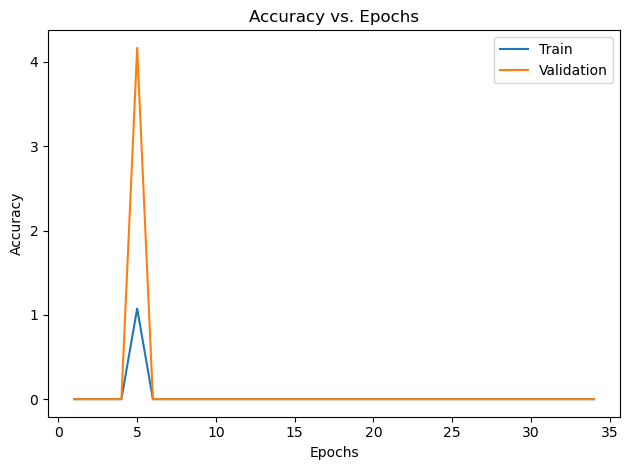

In [28]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/home/lippincm/Documents/Interstellar_Analysis/utils/MLP_utils/utils.py:1017: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/Interstellar_Analysis/utils/MLP_utils/utils.py:1018: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


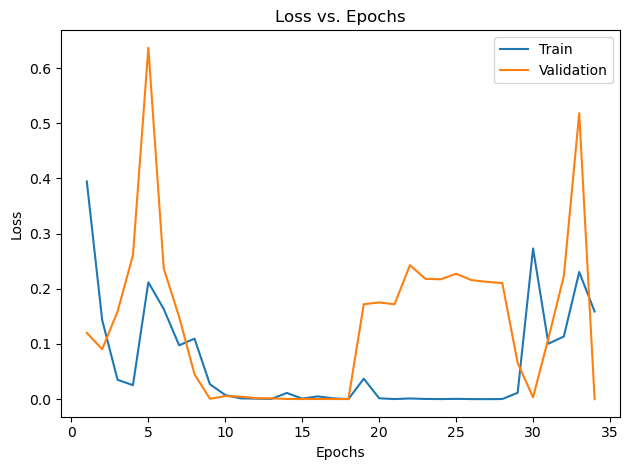

In [29]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

### Test Models on training data

In [30]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    (y_pred_list, y_pred_prob_list, Y_test_list,) = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")
print(len(y_pred_list), len(Y_train))
# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_train):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

print(len(y_pred_list), len(Y_train))

MLP_All_channels
47 93
93 93


/home/lippincm/Documents/Interstellar_Analysis/utils/MLP_utils/utils.py:1081: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f"{save_state_path}/Multi_Class_{model

In [31]:
# convert output tensors into arrays

# list of tensors to list of lists
y_pred_prob_list = [tensor.tolist() for tensor in y_pred_prob_list]
Y_test_list = [tensor.tolist() for tensor in Y_test_list]
# completly flatten list of lists
new_prob_list = []
for i in y_pred_prob_list:
    for j in i:
        new_prob_list.append(j)

new_y_test_list = []
for i in Y_test_list:
    for j in i:
        new_y_test_list.append(j)

# list of lists to array
y_pred_prob_list = np.array(new_prob_list)
Y_test = np.array(new_y_test_list)
print(y_pred_prob_list.shape, Y_test.shape)

(93, 3) (93, 3)


In [32]:
# get the PR curve for each class
pr_curve_0 = precision_recall_curve(Y_test[:, 0], y_pred_prob_list[:, 0])
pr_curve_1 = precision_recall_curve(Y_test[:, 1], y_pred_prob_list[:, 1])
pr_curve_2 = precision_recall_curve(Y_test[:, 2], y_pred_prob_list[:, 2])

In [33]:
# make a dataframe of the precision-recall curves for each class
pr_curve_0 = pd.DataFrame(
    zip(pr_curve_0[0], pr_curve_0[1]),
    columns=["precision", "recall"],
)
pr_curve_0["label"] = 0

pr_curve_1 = pd.DataFrame(
    zip(pr_curve_1[0], pr_curve_1[1]),
    columns=["precision", "recall"],
)
pr_curve_1["label"] = 1

pr_curve_2 = pd.DataFrame(
    zip(pr_curve_2[0], pr_curve_2[1]),
    columns=["precision", "recall"],
)
pr_curve_2["label"] = 2

# make the precision-recall curve dataframe
pr_curve_df = pd.DataFrame(columns=["precision", "recall", "label"])
# concatenate the dataframes together
pr_curve_df = pd.concat([pr_curve_df, pr_curve_0, pr_curve_1, pr_curve_2])

# get the decoded labels
tmp_df = df_values[["new_labels", "labels"]]
# get the unique rows
tmp_df.drop_duplicates(inplace=True)
# make a dict of the labels and new labels
label_dict = dict(zip(tmp_df["new_labels"], tmp_df["labels"]))

# change the label column to the actual labels from the label dict
pr_curve_df["label"] = pr_curve_df["label"].map(label_dict)
pr_curve_df["data_split"] = "train"
pr_curve_df["shuffle"] = mlp_params.SHUFFLE

/tmp/ipykernel_905128/4273854277.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop_duplicates(inplace=True)


In [34]:
main_prob_df = pd.DataFrame(
    columns=[
        "apoptosis_prob",
        "control_prob",
        "pyroptosis_prob",
        "label_true",
        "label_pred",
        "data_split",
        "shuffle",
        "class_name",
    ]
)

In [35]:
class_0_prob = []
class_1_prob = []
class_2_prob = []

for i in y_pred_prob_list:
    class_0_prob.append(i[0])
    class_1_prob.append(i[1])
    class_2_prob.append(i[2])


prob_df = pd.DataFrame(
    zip(class_0_prob, class_1_prob, class_2_prob),
    columns=["apoptosis_prob", "control_prob", "pyroptosis_prob"],
)
label_true = [np.argmax(i) for i in Y_test]

prob_df["label_true"] = label_true
prob_df["label_pred"] = y_pred_list
prob_df["data_split"] = "train"
prob_df["shuffle"] = mlp_params.SHUFFLE
prob_df["class_name"] = prob_df["label_true"].map(label_dict)
metadata_train.reset_index(inplace=True)

prob_df = pd.concat([prob_df, metadata_train], axis=1)

main_prob_df = pd.concat([main_prob_df, prob_df])

In [36]:
# create a master dataframe to store all the model stats
# across all data splits and shuffled data
pr_curve_df_all = pd.DataFrame(
    columns=["precision", "recall", "label", "data_split", "shuffle"]
)
pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)

In [37]:
pr_curve_df_all["data_split"].unique()

array(['train'], dtype=object)

In [38]:
# prior to using the output_stats function, the y_pred_list and Y_test_list must be converted to a single list each
# Y_test_list de code the one hot encoding
Y_test_list = [np.argmax(i) for i in Y_test]

In [39]:
stats_df = output_stats(
    y_pred_list,
    Y_test_list,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        45
           2       1.00      1.00      1.00        43

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93



/tmp/ipykernel_905128/3777910350.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [40]:
stats_df["group"] = "train"
stats_df["shuffle"] = mlp_params.SHUFFLE
stats_df
model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [41]:
# define a final dataframe to store the predictions
final_predictions_df = pd.DataFrame()

In [42]:
# make a df of the predictions and the true labels
y_pred_df = pd.DataFrame(y_pred_list, columns=["predicted_label"])
y_true_df = pd.DataFrame(Y_test_list, columns=["true_label"])
# concat the two dataframes
# final_predictions_df = pd.concat([y_true_df, y_pred_df], axis=1)
y_pred_df = pd.concat([y_true_df, y_pred_df], axis=1)

In [43]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
# metadata_train.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_train], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [44]:
y_pred_df["data_split"] = "train"
y_pred_df["shuffle"] = mlp_params.SHUFFLE

In [45]:
# set path for the model confusion matrices
y_pred_df_path = pathlib.Path(
    f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/training_single_cell_predictions.parquet"
)
y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
if y_pred_df_path.exists():
    predictions_df_tmp = pd.read_parquet(y_pred_df_path)
    if len(predictions_df_tmp["shuffle"].unique()) > 1:
        pass
    elif predictions_df_tmp["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([predictions_df_tmp, y_pred_df], axis=0)
        metrics_df.to_parquet(y_pred_df_path, index=False)
else:
    y_pred_df.to_parquet(y_pred_df_path, index=False)

In [46]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)

## Test models on Validation data

In [47]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    (y_pred_list, y_pred_prob_list, Y_test_list) = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_val):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MLP_All_channels


/home/lippincm/Documents/Interstellar_Analysis/utils/MLP_utils/utils.py:1081: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f"{save_state_path}/Multi_Class_{model

In [48]:
# convert output tensors into arrays

# list of tensors to list of lists
y_pred_prob_list = [tensor.tolist() for tensor in y_pred_prob_list]
Y_test_list = [tensor.tolist() for tensor in Y_test_list]
# completly flatten list of lists
new_prob_list = []
for i in y_pred_prob_list:
    for j in i:
        new_prob_list.append(j)

new_y_test_list = []
for i in Y_test_list:
    for j in i:
        new_y_test_list.append(j)

# list of lists to array
y_pred_prob_list = np.array(new_prob_list)
Y_test = np.array(new_y_test_list)

In [49]:
# get the PR curve for each class
pr_curve_0 = precision_recall_curve(Y_test[:, 0], y_pred_prob_list[:, 0])
pr_curve_1 = precision_recall_curve(Y_test[:, 1], y_pred_prob_list[:, 1])
pr_curve_2 = precision_recall_curve(Y_test[:, 2], y_pred_prob_list[:, 2])

In [50]:
# make a dataframe of the precision-recall curves for each class
pr_curve_0 = pd.DataFrame(
    zip(pr_curve_0[0], pr_curve_0[1]),
    columns=["precision", "recall"],
)
pr_curve_0["label"] = 0

pr_curve_1 = pd.DataFrame(
    zip(pr_curve_1[0], pr_curve_1[1]),
    columns=["precision", "recall"],
)
pr_curve_1["label"] = 1

pr_curve_2 = pd.DataFrame(
    zip(pr_curve_2[0], pr_curve_2[1]),
    columns=["precision", "recall"],
)
pr_curve_2["label"] = 2

# make the precision-recall curve dataframe
pr_curve_df = pd.DataFrame(columns=["precision", "recall", "label"])
pr_curve_df = pd.concat([pr_curve_df, pr_curve_0, pr_curve_1, pr_curve_2])


# get the decoded labels
tmp_df = df_values[["new_labels", "labels"]]
# get the unique rows
tmp_df.drop_duplicates(inplace=True)
# make a dict of the labels and new labels
label_dict = dict(zip(tmp_df["new_labels"], tmp_df["labels"]))

# change the label column to the actual labels from the label dict
pr_curve_df["label"] = pr_curve_df["label"].map(label_dict)
pr_curve_df["data_split"] = "validation"
pr_curve_df["shuffle"] = mlp_params.SHUFFLE

/tmp/ipykernel_905128/95662448.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop_duplicates(inplace=True)


In [51]:
# create a master dataframe to store all the model stats
# across all data splits and shuffled data
pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)

/tmp/ipykernel_905128/2243255322.py:3: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)


In [52]:
pr_curve_df_all["data_split"].unique()

array(['train', 'validation'], dtype=object)

In [53]:
class_0_prob = []
class_1_prob = []
class_2_prob = []

for i in y_pred_prob_list:
    class_0_prob.append(i[0])
    class_1_prob.append(i[1])
    class_2_prob.append(i[2])


prob_df = pd.DataFrame(
    zip(class_0_prob, class_1_prob, class_2_prob),
    columns=["apoptosis_prob", "control_prob", "pyroptosis_prob"],
)
label_true = [np.argmax(i) for i in Y_test]

prob_df["label_true"] = label_true
prob_df["label_pred"] = y_pred_list
prob_df["data_split"] = "validation"
prob_df["shuffle"] = mlp_params.SHUFFLE
prob_df["class_name"] = prob_df["label_true"].map(label_dict)
metadata_val.reset_index(inplace=True)

prob_df = pd.concat([prob_df, metadata_val], axis=1)
main_prob_df = pd.concat([main_prob_df, prob_df])

/tmp/ipykernel_905128/2502681538.py:25: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  main_prob_df = pd.concat([main_prob_df, prob_df])


In [54]:
Y_test_list = [np.argmax(i) for i in Y_test]

In [55]:
stats_df = output_stats(
    y_pred_list,
    Y_test_list,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        11

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



/tmp/ipykernel_905128/3777910350.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [56]:
stats_df["group"] = "validation"
stats_df["shuffle"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_905128/4189047634.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


In [57]:
# make a df of the predictions and the true labels
y_pred_df = pd.DataFrame(y_pred_list, columns=["predicted_label"])
y_true_df = pd.DataFrame(Y_test_list, columns=["true_label"])
# concat the two dataframes
# final_predictions_df = pd.concat([y_true_df, y_pred_df], axis=1)
y_pred_df = pd.concat([y_true_df, y_pred_df], axis=1)

In [58]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
# metadata_val.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_val], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [59]:
y_pred_df["data_split"] = "validation"
y_pred_df["shuffle"] = mlp_params.SHUFFLE

In [60]:
# set path for the model confusion matrices
y_pred_df_path = pathlib.Path(
    f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/validation_single_cell_predictions.parquet"
)
y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
if y_pred_df_path.exists():
    predictions_df_tmp = pd.read_parquet(y_pred_df_path)
    if len(predictions_df_tmp["shuffle"].unique()) > 1:
        pass
    elif predictions_df_tmp["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([predictions_df_tmp, y_pred_df], axis=0)
        metrics_df.to_parquet(y_pred_df_path, index=False)
else:
    y_pred_df.to_parquet(y_pred_df_path, index=False)

In [61]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)

## Testing on the test data

In [62]:
# create a dataframe to store the model confusion matrix
data_split_conf_mat_df_all = pd.DataFrame(
    columns=["True_Label", "Predicted_Label", "Count", "data_split", "Recall"]
)

In [63]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    (y_pred_list, y_pred_prob_list, Y_test_list,) = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

MLP_All_channels


/home/lippincm/Documents/Interstellar_Analysis/utils/MLP_utils/utils.py:1081: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f"{save_state_path}/Multi_Class_{model

In [64]:
# convert output tensors into arrays

# list of tensors to list of lists
y_pred_prob_list = [tensor.tolist() for tensor in y_pred_prob_list]
Y_test_list = [tensor.tolist() for tensor in Y_test_list]
# completly flatten list of lists
new_prob_list = []
for i in y_pred_prob_list:
    for j in i:
        new_prob_list.append(j)

new_y_test_list = []
for i in Y_test_list:
    for j in i:
        new_y_test_list.append(j)

# list of lists to array
y_pred_prob_list = np.array(new_prob_list)
Y_test = np.array(new_y_test_list)

In [65]:
# get the PR curve for each class
pr_curve_0 = precision_recall_curve(Y_test[:, 0], y_pred_prob_list[:, 0])
pr_curve_1 = precision_recall_curve(Y_test[:, 1], y_pred_prob_list[:, 1])
pr_curve_2 = precision_recall_curve(Y_test[:, 2], y_pred_prob_list[:, 2])

In [66]:
# make a dataframe of the precision-recall curves for each class
pr_curve_0 = pd.DataFrame(
    zip(pr_curve_0[0], pr_curve_0[1]),
    columns=["precision", "recall"],
)
pr_curve_0["label"] = 0

pr_curve_1 = pd.DataFrame(
    zip(pr_curve_1[0], pr_curve_1[1]),
    columns=["precision", "recall"],
)
pr_curve_1["label"] = 1

pr_curve_2 = pd.DataFrame(
    zip(pr_curve_2[0], pr_curve_2[1]),
    columns=["precision", "recall"],
)
pr_curve_2["label"] = 2

# make the precision-recall curve dataframe
pr_curve_df = pd.DataFrame(columns=["precision", "recall", "label"])
pr_curve_df = pd.concat([pr_curve_df, pr_curve_0, pr_curve_1, pr_curve_2])


# get the decoded labels
tmp_df = df_values[["new_labels", "labels"]]
# get the unique rows
tmp_df.drop_duplicates(inplace=True)
# make a dict of the labels and new labels
label_dict = dict(zip(tmp_df["new_labels"], tmp_df["labels"]))

# change the label column to the actual labels from the label dict
pr_curve_df["label"] = pr_curve_df["label"].map(label_dict)
pr_curve_df["data_split"] = "testing"
pr_curve_df["shuffle"] = mlp_params.SHUFFLE

/tmp/ipykernel_905128/1312179888.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop_duplicates(inplace=True)


In [67]:
# create a master dataframe to store all the model stats
# across all data splits and shuffled data

pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)

/tmp/ipykernel_905128/2109324303.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  pr_curve_df_all = pd.concat([pr_curve_df_all, pr_curve_df], axis=0)


In [68]:
pr_curve_df_all["data_split"].unique()

array(['train', 'validation', 'testing'], dtype=object)

In [69]:
class_0_prob = []
class_1_prob = []
class_2_prob = []

for i in y_pred_prob_list:
    class_0_prob.append(i[0])
    class_1_prob.append(i[1])
    class_2_prob.append(i[2])


prob_df = pd.DataFrame(
    zip(class_0_prob, class_1_prob, class_2_prob),
    columns=["apoptosis_prob", "control_prob", "pyroptosis_prob"],
)
label_true = [np.argmax(i) for i in Y_test]

prob_df["label_true"] = label_true
prob_df["label_pred"] = y_pred_list
prob_df["data_split"] = "testing"
prob_df["shuffle"] = mlp_params.SHUFFLE
prob_df["class_name"] = prob_df["label_true"].map(label_dict)
metadata_test.reset_index(inplace=True)

prob_df = pd.concat([prob_df, metadata_test], axis=1)
main_prob_df = pd.concat([main_prob_df, prob_df])

/tmp/ipykernel_905128/1664437899.py:25: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  main_prob_df = pd.concat([main_prob_df, prob_df])


In [70]:
Y_test_list = [np.argmax(i) for i in Y_test]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        18

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Precision for class 0: 1.0
Recall for class 0: 1.0
Precision for class 1: 1.0
Recall for class 1: 1.0
Precision for class 2: 1.0
Recall for class 2: 1.0
3


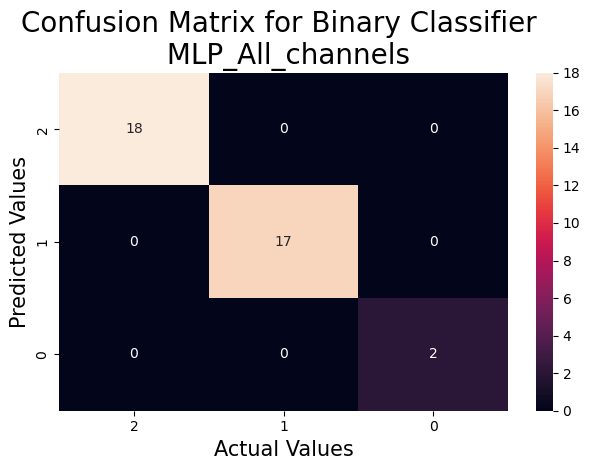

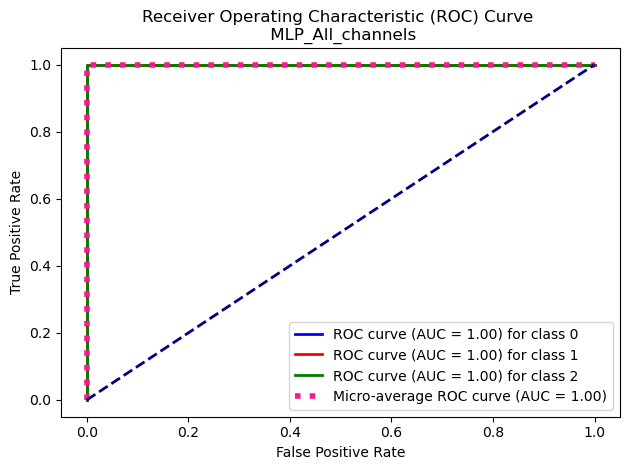

In [71]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test_list,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")
plt.close()

In [72]:
# make a df of the predictions and the true labels
y_pred_df = pd.DataFrame(y_pred_list, columns=["predicted_label"])
y_true_df = pd.DataFrame(Y_test_list, columns=["true_label"])
# concat the two dataframes
# final_predictions_df = pd.concat([y_true_df, y_pred_df], axis=1)
y_pred_df = pd.concat([y_true_df, y_pred_df], axis=1)

In [73]:
# merge y_pred_df with metadata_holdout while keeping the index of metadata_holdout
# metadata_test.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_test], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [74]:
y_pred_df["data_split"] = "test"
y_pred_df["shuffle"] = mlp_params.SHUFFLE

In [75]:
# set path for the model confusion matrices
y_pred_df_path = pathlib.Path(
    f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/testing_single_cell_predictions.parquet"
)
y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
if y_pred_df_path.exists():
    predictions_df_tmp = pd.read_parquet(y_pred_df_path)
    if len(predictions_df_tmp["shuffle"].unique()) > 1:
        pass
    elif predictions_df_tmp["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([predictions_df_tmp, y_pred_df], axis=0)
        metrics_df.to_parquet(y_pred_df_path, index=False)
else:
    y_pred_df.to_parquet(y_pred_df_path, index=False)

In [76]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)

In [77]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [78]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "testing"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [79]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [80]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "testing"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffle"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

In [81]:
ax = sns.heatmap(confusion_matrix_df, annot=True)
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)

plt.close()

In [82]:
stats_df = output_stats(
    y_pred_list,
    Y_test_list,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        18

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



/tmp/ipykernel_905128/3777910350.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [83]:
stats_df["group"] = "test"
stats_df["shuffle"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_905128/309341788.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


### Save Files

In [84]:
# set path for the model confusion matrices
predictions_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
predictions_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
predictions_file = pathlib.Path(f"{predictions_path}/single_cell_predictions.parquet")
if predictions_file.exists():
    predictions_df_tmp = pd.read_parquet(predictions_file)
    if len(predictions_df_tmp["shuffle"].unique()) > 1:
        pass
    elif predictions_df_tmp["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([predictions_df_tmp, final_predictions_df], axis=0)
        metrics_df.to_parquet(predictions_file, index=False)
else:
    final_predictions_df.to_parquet(predictions_file, index=False)

In [85]:
# set path for the model confusion matrices
matrix_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
matrix_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
matrix_file = pathlib.Path(f"{matrix_path}/confusion_matrices.parquet")
if matrix_file.exists():
    metrics_df = pd.read_parquet(matrix_file)
    if len(metrics_df["shuffle"].unique()) > 1:
        pass
    elif metrics_df["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, data_split_conf_mat_df_all], axis=0)
        metrics_df.to_parquet(matrix_file, index=False)
else:
    data_split_conf_mat_df_all.to_parquet(matrix_file, index=False)

In [86]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.parquet")
if metrics_file.exists():
    metrics_df = pd.read_parquet(metrics_file)
    if len(metrics_df["shuffle"].unique()) > 1:
        pass
    elif metrics_df["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_parquet(metrics_file, index=False)
else:
    model_stats_df.to_parquet(metrics_file, index=False)

In [87]:
# set path for the model training metrics
pr_curve_file_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
pr_curve_file_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
pr_curve_file = pathlib.Path(f"{pr_curve_file_path}/PR_curves.parquet")
if pr_curve_file.exists():
    pr_curve_df_old = pd.read_parquet(pr_curve_file)
    if len(pr_curve_df_old["shuffle"].unique()) > 1:
        pass
    elif pr_curve_df_old["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        pr_curve_df_old = pd.concat([pr_curve_df_old, pr_curve_df_all], axis=0)
        pr_curve_df_old.to_parquet(pr_curve_file, index=False)
else:
    pr_curve_df_all.to_parquet(pr_curve_file, index=False)

In [88]:
# set path for the model training metrics
probabilties_df_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
probabilties_df_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
probabilties_df_file = pathlib.Path(f"{probabilties_df_path}/probabilities.parquet")
if probabilties_df_file.exists():
    probabilties_df_old = pd.read_parquet(probabilties_df_file)
    if len(probabilties_df_old["shuffle"].unique()) > 1:
        pass
    elif probabilties_df_old["shuffle"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        probabilties_df_old = pd.concat([probabilties_df_old, main_prob_df], axis=0)
        probabilties_df_old.to_parquet(probabilties_df_file, index=False)
else:
    main_prob_df.to_parquet(probabilties_df_file, index=False)

In [89]:
main_prob_df["data_split"].unique()

array(['train', 'validation', 'testing'], dtype=object)